#Installs&Data

In [ ]:
!gdown '18LUn6G999SpzGISC6kJVvdz-jMoTYJFB'

Downloading...
From: https://drive.google.com/uc?id=18LUn6G999SpzGISC6kJVvdz-jMoTYJFB
To: /content/data_3.zip
100% 94.4M/94.4M [00:01<00:00, 56.0MB/s]


In [ ]:
!unzip './data_3.zip'

Archive:  ./data_3.zip
   creating: data/
   creating: data/test/
   creating: data/test/Bedroom/
  inflating: data/test/Bedroom/image_0003.jpg  
  inflating: data/test/Bedroom/image_0004.jpg  
  inflating: data/test/Bedroom/image_0006.jpg  
  inflating: data/test/Bedroom/image_0007.jpg  
  inflating: data/test/Bedroom/image_0008.jpg  
  inflating: data/test/Bedroom/image_0011.jpg  
  inflating: data/test/Bedroom/image_0013.jpg  
  inflating: data/test/Bedroom/image_0014.jpg  
  inflating: data/test/Bedroom/image_0016.jpg  
  inflating: data/test/Bedroom/image_0017.jpg  
  inflating: data/test/Bedroom/image_0018.jpg  
  inflating: data/test/Bedroom/image_0019.jpg  
  inflating: data/test/Bedroom/image_0020.jpg  
  inflating: data/test/Bedroom/image_0021.jpg  
  inflating: data/test/Bedroom/image_0024.jpg  
  inflating: data/test/Bedroom/image_0026.jpg  
  inflating: data/test/Bedroom/image_0029.jpg  
  inflating: data/test/Bedroom/image_0030.jpg  
  inflating: data/test/Bedroom/image_0

#Imports

In [ ]:
import os
import cv2
import time
import glob
import IPython
import skimage
import warnings
import cv2 as cv
import statistics
import matplotlib
import numpy as np
import pandas as pd
import scipy.spatial
from typing import List
import scipy.io as scio
from sklearn.svm import SVC
from tabulate import tabulate
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn import preprocessing
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from scipy.spatial import distance
from skimage import io, img_as_float32
from skimage.measure import regionprops
from scipy.spatial.distance import cdist
from skimage.transform import rescale, resize
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skimage.feature import plot_matches, peak_local_max, hog

#Code

##Visualize

In [ ]:
# Skimage gives us some lossy conversion errors that we really don't care about
# so we suppress them
warnings.filterwarnings("ignore", "", UserWarning)


def create_results_webpage(
    train_image_paths,
    test_image_paths,
    train_labels,
    test_labels,
    categories,
    abbr_categories,
    predicted_categories,
		verbose
):
	"""
	Starter code prepared by James Hays for CSCI 1430 Computer Vision
	Converted to Python by Brendan Walsh

	This function creates a webpage (html and images) visualizing the
	classiffication results. This webpage will contain:
	 (1) A confusion matrix plot
	 (2) A table with one row per category, with 4 columns - training
		 examples, true positives, false positives, and false negatives.

	False positives are instances claimed as that category but belonging to
	another category, e.g. in the 'forest' row an image that was classified
	as 'forest' but is actually 'mountain'. This same image would be
	considered a false negative in the 'mountain' row, because it should have
	been claimed by the 'mountain' classifier but was not.

	This webpage is similar to the one created for the SUN database in
	2010: http://people.csail.mit.edu/jxiao/SUN/classification397.html
	"""

	if verbose:print("Creating results_webpage/index.html, thumbnails, and confusion matrix.")

	# Number of examples of training examples, true positives, false positives,
	# and false negatives. Thus the table will be num_samples * 4 images wide
	# (unless there aren't enough images)
	num_samples = 2
	thumbnail_height = 75  # pixels
	num_categories = len(categories)

	# Convert everything over to numpy arrays
	categories = np.array(categories)
	predicted_categories = np.array(predicted_categories)
	train_labels = np.array(train_labels)
	test_labels = np.array(test_labels)

	# Delete the old thumbnails, if there are any
	files = glob.glob("static/images/*.jpg")
	for f in files:
		os.remove(f)

	if not os.path.isdir("static"):
		if verbose:print("static")
		os.mkdir("static")
	if not os.path.isdir("static/template"):
		if verbose:print("template")
		os.mkdir("static/template")
	if not os.path.isdir("static/images"):
		if verbose:print("images")
		os.mkdir("static/images")

	### Create And Save Confusion Matrix ###
	# Based on the predicted category for each test case, we will now build a
	# confusion matrix. Entry (i,j) in this matrix well be the proportion of
	# times a test image of ground truth category i was predicted to be
	# category j. An identity matrix is the ideal case. You should expect
	# roughly 50-95% along the diagonal depending on your features,
	# classifiers, and particular categories. For example, suburb is very easy
	# to recognize.
	accuracy = 0
	with open("static/template/index.html", "w+") as f:

			# Initialize the matrix
			confusion_matrix = np.zeros((num_categories, num_categories))

			# Iterate over predicted results (this is like, several hundred items long)
			for i, cat in enumerate(predicted_categories):
					# Find the row and column corresponding to the label of this entry
					# The row is the ground truth label and the column is the found label
					row = np.argwhere(categories == test_labels[i])[0][0]
					column = np.argwhere(categories == predicted_categories[i])[0][0]

					# Add 1 to the matrix for that row/col
					# This way we build up a histogram from our labeled data
					confusion_matrix[row][column] += 1

			# If the number of training examples and test cases are not equal, this
			# statement will be invalid!
			# TODO: That's an old comment left over from the matlab code that I don't
			# think still applies
			num_test_per_cat = len(test_labels) / num_categories
			confusion_matrix = confusion_matrix / float(num_test_per_cat)
			accuracy = np.mean(np.diag(confusion_matrix))
			if not verbose:
				return accuracy

			if verbose:print(
					"Accuracy (mean of diagonal of confusion matrix) is {:2.3%}".format(
							accuracy
					)
			)

			# plasma is the most easily-interpreted color map I've found so far
			if verbose:
				plt.figure(figsize=(7,7))
				plt.imshow(confusion_matrix, cmap="gray", interpolation="nearest")

				# We put the shortened labels (e.g. "sub" for "suburb") on the x axis
				locs, labels = plt.xticks()
				plt.xticks(np.arange(num_categories), abbr_categories)

				# Full labels go on y
				locs, labels = plt.yticks()
				plt.yticks(np.arange(num_categories), categories)

				# Save the result
				plt.savefig("static/confusion_matrix.png", bbox_inches="tight")

			## Create webpage header
			f.write("<!DOCTYPE html>\n")
			f.write("<html>\n")
			f.write("<head>\n")
			f.write(
					"<link href="
					"http://fonts.googleapis.com/css?family=Nunito:300|Crimson+Text|Droid+Sans+Mono"
					" rel="
					"stylesheet"
					" type="
					"text/css"
					">\n"
			)
			f.write('<style type="text/css">\n')

			f.write("body {\n")
			f.write("  margin: 0px;\n")
			f.write("  width: 100%;\n")
			f.write("  font-family: " "Crimson Text" ", serif;\n")
			f.write("  background: #fcfcfc;\n")
			f.write("}\n")
			f.write("table td {\n")
			f.write("  text-align: center;\n")
			f.write("  vertical-align: middle;\n")
			f.write("}\n")
			f.write("h1 {\n")
			f.write("  font-family: " "Nunito" ", sans-serif;\n")
			f.write("  font-weight: normal;\n")
			f.write("  font-size: 28px;\n")
			f.write("  margin: 25px 0px 0px 0px;\n")
			f.write("  text-transform: lowercase;\n")
			f.write("}\n")
			f.write(".container {\n")
			f.write("  margin: 0px auto 0px auto;\n")
			f.write("  width: 1160px;\n")
			f.write("}\n")

			f.write("</style>\n")
			f.write("</head>\n")
			f.write("<body>\n\n")

			f.write('<div class="container">\n\n\n')
			f.write("<center>\n")
			f.write("<h1>Scene classification results visualization</h1>\n")
			f.write('<img src="confusion_matrix.png">\n\n')
			f.write("<br>\n")
			f.write(
					"Accuracy (mean of diagonal of confusion matrix) is %2.3f\n" % (accuracy)
			)
			f.write("<p>\n\n")

			## Create results table
			f.write("<table border=0 cellpadding=4 cellspacing=1>\n")
			f.write("<tr>\n")
			f.write("<th>Category name</th>\n")
			f.write("<th>Accuracy</th>\n")
			f.write("<th colspan=%d>Sample training images</th>\n" % num_samples)
			f.write("<th colspan=%d>Sample true positives</th>\n" % num_samples)
			f.write("<th colspan=%d>False positives with true label</th>\n" % num_samples)
			f.write(
					"<th colspan=%d>False negatives with wrong predicted label</th>\n"
					% num_samples
			)
			f.write("</tr>\n")

			for i, cat in enumerate(categories):
					f.write("<tr>\n")

					f.write("<td>")
					# category name
					f.write("%s" % cat)
					f.write("</td>\n")

					f.write("<td>")
					# category accuracy
					f.write("%.3f" % confusion_matrix[i][i])
					f.write("</td>\n")

					# Collect num_samples random paths to images of each type.
					# Training examples.
					train_examples = np.take(
							train_image_paths, np.argwhere(train_labels == cat)
					)

					# True positives. There might not be enough of these if the classifier
					# is bad
					true_positives = np.take(
							test_image_paths,
							np.argwhere(
									np.logical_and(test_labels == cat, predicted_categories == cat)
							),
					)

					# False positives. There might not be enough of them if the classifier
					# is good
					false_positive_inds = np.argwhere(
							np.logical_and(
									np.invert(cat == test_labels), cat == predicted_categories
							)
					)
					false_positives = np.take(test_image_paths, false_positive_inds)
					false_positive_labels = np.take(test_labels, false_positive_inds)

					# False negatives. There might not be enough of them if the classifier
					# is good
					false_negative_inds = np.argwhere(
							np.logical_and(
									cat == test_labels, np.invert(cat == predicted_categories)
							)
					)
					false_negatives = np.take(test_image_paths, false_negative_inds)
					false_negative_labels = np.take(predicted_categories, false_negative_inds)

					# Randomize each list of files
					np.random.shuffle(train_examples)
					np.random.shuffle(true_positives)

					# HACK: Well, sort of a hack. We need to shuffle the false_positives
					# and their labels in the same exact order, so we get the RNG state,
					# save it, shuffle, restore, then shuffle the other list so that they
					# shuffle in tandem.
					rng_state = np.random.get_state()
					np.random.shuffle(false_positives)
					np.random.set_state(rng_state)
					np.random.shuffle(false_positive_labels)

					rng_state = np.random.get_state()
					np.random.shuffle(false_negatives)
					np.random.set_state(rng_state)
					np.random.shuffle(false_negative_labels)

					# Truncate each list to be at most num_samples long
					train_examples = train_examples[0 : min(len(train_examples), num_samples)]
					true_positives = true_positives[0 : min(len(true_positives), num_samples)]
					false_positives = false_positives[
							0 : min(len(false_positives), num_samples)
					]
					false_positive_labels = false_positive_labels[
							0 : min(len(false_positive_labels), num_samples)
					]
					false_negatives = false_negatives[
							0 : min(len(false_negatives), num_samples)
					]
					false_negative_labels = false_negative_labels[
							0 : min(len(false_negative_labels), num_samples)
					]

					# Sample training images
					# Create and save all of the thumbnails
					for j in range(num_samples):
							if j + 1 <= len(train_examples):
									thisExample = train_examples[j][0]
									tmp = skimage.io.imread(thisExample)
									height, width = rescale_2(tmp.shape, thumbnail_height)
									tmp = skimage.transform.resize(
											tmp, (height, width), anti_aliasing=True, mode="wrap"
									)

									name = os.path.basename(thisExample)
									tmp_uint8 = (tmp * 255).astype(np.uint8)
									skimage.io.imsave(
											"static/images/" + cat + "_" + name,
											tmp_uint8,
											quality=100,
									)
									f.write("<td bgcolor=LightBlue>")
									f.write(
											'<img src="%s" width=%d height=%d>'
											% ("images/" + cat + "_" + name, width, height)
									)
									f.write("</td>\n")
							else:
									f.write("<td bgcolor=LightBlue>")
									f.write("</td>\n")

					for j in range(num_samples):
							if j + 1 <= len(true_positives):
									thisExample = true_positives[j][0]
									tmp = skimage.io.imread(thisExample)
									height, width = rescale_2(tmp.shape, thumbnail_height)
									tmp = skimage.transform.resize(
											tmp, (height, width), anti_aliasing=True, mode="wrap"
									)

									name = os.path.basename(thisExample)
									tmp_uint8 = (tmp * 255).astype(np.uint8)
									skimage.io.imsave(
											"static/images/" + cat + "_" + name,
											tmp_uint8,
											quality=100,
									)
									f.write("<td bgcolor=LightGreen>")
									f.write(
											'<img src="%s" width=%d height=%d>'
											% ("images/" + cat + "_" + name, width, height)
									)
									f.write("</td>\n")
							else:
									f.write("<td bgcolor=LightGreen>")
									f.write("</td>\n")

					for j in range(num_samples):
							if j + 1 <= len(false_positives):
									thisExample = false_positives[j][0]
									tmp = skimage.io.imread(thisExample)
									height, width = rescale_2(tmp.shape, thumbnail_height)
									tmp = skimage.transform.resize(
											tmp, (height, width), anti_aliasing=True, mode="wrap"
									)

									name = os.path.basename(thisExample)
									tmp_uint8 = (tmp * 255).astype(np.uint8)
									skimage.io.imsave(
											"static/images/" + cat + "_" + name,
											tmp_uint8,
											quality=100,
									)
									f.write("<td bgcolor=LightCoral>")
									f.write(
											'<img src="%s" width=%d height=%d>'
											% ("images/" + cat + "_" + name, width, height)
									)
									f.write("<br><small>%s</small>" % false_positive_labels[j][0])
									f.write("</td>\n")
							else:
									f.write("<td bgcolor=LightCoral>")
									f.write("</td>\n")

					for j in range(num_samples):
							if j + 1 <= len(false_negatives):
									thisExample = false_negatives[j][0]
									tmp = skimage.io.imread(thisExample)
									height, width = rescale_2(tmp.shape, thumbnail_height)
									tmp = skimage.transform.resize(
											tmp, (height, width), anti_aliasing=True, mode="wrap"
									)

									name = os.path.basename(thisExample)
									tmp_uint8 = (tmp * 255).astype(np.uint8)
									skimage.io.imsave(
											"static/images/" + cat + "_" + name,
											tmp_uint8,
											quality=100,
									)
									f.write("<td bgcolor=#FFBB55>")
									f.write(
											'<img src="%s" width=%d height=%d>'
											% ("images/" + cat + "_" + name, width, height)
									)
									f.write("<br><small>%s</small>" % false_negative_labels[j][0])
									f.write("</td>\n")
							else:
									f.write("<td bgcolor=#FFBB55>")
									f.write("</td>\n")

					f.write("</tr>\n")

			f.write("<tr>\n")
			f.write("<th>Category name</th>\n")
			f.write("<th>Accuracy</th>\n")
			f.write("<th colspan=%d>Sample training images</th>\n" % num_samples)
			f.write("<th colspan=%d>Sample true positives</th>\n" % num_samples)
			f.write("<th colspan=%d>False positives with true label</th>\n" % num_samples)
			f.write(
					"<th colspan=%d>False negatives with wrong predicted label</th>\n"
					% num_samples
			)
			f.write("</tr>\n")

			f.write("</table>\n")
			f.write("</center>\n\n\n")
			f.write("</div>\n")

			## Create end of web page
			f.write("</body>\n")
			f.write("</html>\n")

	if verbose:print("Wrote results page to static/index.html.")
	return accuracy

def rescale_2(dims, thumbnail_height):
	height = dims[1]
	factor = thumbnail_height / height
	left = int(round(dims[0] * factor))
	right = int(round(dims[1] * factor))
	return (left, right)

##Helpers

In [ ]:
def get_image_paths(data_path, categories, num_train_per_cat):
    """
    This function returns lists containing the file path for each train
    and test image, as well as lists with the label of each train and
    test image. By default both lists will be 1500x1, where each
    entry is a char array (or string).
    """

    num_categories = len(categories)  # number of scene categories.

    # This paths for each training and test image. By default it will have 1500
    # entries (15 categories * 100 training and test examples each)
    train_image_paths = [None] * (num_categories * num_train_per_cat)
    test_image_paths = [None] * (num_categories * num_train_per_cat)
    val_image_paths = []

    # The name of the category for each training and test image. With the
    # default setup, these arrays will actually be the same, but they are built
    # independently for clarity and ease of modification.
    train_labels = [None] * (num_categories * num_train_per_cat)
    test_labels = [None] * (num_categories * num_train_per_cat)
    val_labels = []


    for i, cat in enumerate(categories):
        images = glob.glob(os.path.join(data_path, 'train', cat, '*.jpg'))

        for j in range(num_train_per_cat):
            train_image_paths[i * num_train_per_cat + j] = images[j]
            train_labels[i * num_train_per_cat + j] = cat

        images = glob.glob(os.path.join(data_path, 'test', cat, '*.jpg'))
        for j in range(len(images)):
          if j < num_train_per_cat:
            test_image_paths[i * num_train_per_cat + j] = images[j]
            test_labels[i * num_train_per_cat + j] = cat
          else:
            # add any excess images to val set
            val_image_paths.append(images[j])
            val_labels.append(cat)

    return np.array(train_image_paths), np.array(test_image_paths), np.array(val_image_paths), np.array(train_labels), np.array(test_labels), np.array(val_labels)

##Main

In [ ]:
def projSceneRecBoW(feature = 'placeholder', classifier = 'placeholder', verbose = True, add_val = True,
                    k = 1, distance_metric = 'euclidean', nbnn=False, coding_type='TCB', sigma = 0.29,
                    kernel='linear', fine_tune = False, vocab_size = 200, cells_per_block = (4,4), pixels_per_cell = (4,4)):
    '''
    For this project, you will need to report performance for three
    combinations of features / classifiers. We recommend that you code them in
    this order:
        1) Tiny image features and nearest neighbor classifier
        2) Bag of word features and nearest neighbor classifier
        3) Bag of word features and linear SVM classifier
    The starter code is initialized to 'placeholder' just so that the starter
    code does not crash when run unmodified and you can get a preview of how
    results are presented.

    Interpreting your performance with 100 training examples per category:
     accuracy  =   0 -> Something is broken.
     accuracy ~= .07 -> Your performance is equal to chance.
                        Something is broken or you ran the starter code unchanged.
     accuracy ~= .20 -> Rough performance with tiny images and nearest
                        neighbor classifier. Performance goes up a few
                        percentage points with K-NN instead of 1-NN.
     accuracy ~= .20 -> Rough performance with tiny images and linear SVM
                        classifier. Although the accuracy is about the same as
                        nearest neighbor, the confusion matrix is very different.
     accuracy ~= .40 -> Rough performance with bag of word and nearest
                        neighbor classifier. Can reach .60 with K-NN and
                        different distance metrics.
     accuracy ~= .50 -> You've gotten things roughly correct with bag of
                        word and a linear SVM classifier.
     accuracy >= .70 -> You've also tuned your parameters well. E.g. number
                        of clusters, SVM regularization, number of patches
                        sampled when building vocabulary, size and step for
                        dense features.
     accuracy >= .80 -> You've added in spatial information somehow or you've
                        added additional, complementary image features. This
                        represents state of the art in Lazebnik et al 2006.
     accuracy >= .85 -> You've done extremely well. This is the state of the
                        art in the 2010 SUN database paper from fusing many
                        features. Don't trust this number unless you actually
                        measure many random splits.
     accuracy >= .90 -> You used modern deep features trained on much larger
                        image databases.
     accuracy >= .96 -> You can beat a human at this task. This isn't a
                        realistic number. Some accuracy calculation is broken
                        or your classifier is cheating and seeing the test
                        labels.
    '''

    # Step 0: Set up parameters, category list, and image paths.
    FEATURE = feature
    CLASSIFIER = classifier

    # This is the path the script will look at to load images from.
    data_path = '/content/data/'

    # This is the list of categories / directories to use. The categories are
    # somewhat sorted by similarity so that the confusion matrix looks more
    # structured (indoor and then urban and then rural).
    categories = ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office',
                  'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street',
                  'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest']

    # This list of shortened category names is used later for visualization.
    abbr_categories = ['Kit', 'Sto', 'Bed', 'Liv', 'Off', 'Ind', 'Sub',
                       'Cty', 'Bld', 'St', 'HW', 'OC', 'Cst', 'Mnt', 'For']

    # Number of training examples per category to use. Max is 100. For
    # simplicity, we assume this is the number of test cases per category as
    # well.
    num_train_per_cat = 100

    # This function returns string arrays containing the file path for each train
    # and test image, as well as string arrays with the label of each train and
    # test image. By default all four of these arrays will be 1500x1 where each
    # entry is a string.
    if verbose:  print('Getting paths and labels for all train and test data.')
    train_image_paths, test_image_paths, val_image_paths, train_labels, test_labels, val_labels  = \
        get_image_paths(data_path, categories, num_train_per_cat)

    # here we use the val set as a train set
    # to train on more images
    if add_val:
      train_image_paths = np.append(train_image_paths, val_image_paths)
      train_labels = np.append(train_labels, val_labels)
    # failed miserably the RAM can't handle the clustering
    # but will use for fine-tuning the svm

    #   train_image_paths  1500x1   np.array
    #   test_image_paths   1500x1   np.array
    #   val_image_paths    1485x1   np.array
    #   train_labels       1500x1   np.array
    #   test_labels        1500x1   np.array
    #   val_labels         1485x1   np.array

    ############################################################################
    ## Step 1: Represent each image with the appropriate feature
    # Each function to construct features should return an N x d matrix, where
    # N is the number of paths passed to the function and d is the
    # dimensionality of each image representation. See the starter code for
    # each function for more details.
    ############################################################################

    if verbose:print('Using %s representation for images.' % FEATURE)

    if FEATURE.lower() == 'tiny_image':
        if verbose:print('Loading tiny images...')
        # YOU CODE get_tiny_images (see student.py)
        train_image_feats = get_tiny_images(verbose, train_image_paths)
        test_image_feats = get_tiny_images(verbose, test_image_paths)
        if verbose:print('Tiny images loaded.')

    elif FEATURE.lower() == 'bag_of_words':
        # Because building the vocabulary takes a long time, we save the generated
        # vocab to a file and re-load it each time to make testing faster. If
        # you need to re-generate the vocab (for example if you change its size
        # or the length of your feature vectors), simply delete the vocab.npy
        # file and re-run main.py
        if not os.path.isfile('vocab_'+str(vocab_size)+'.npy'):
            if verbose:print('No existing visual word vocabulary found. Computing one from training images.')

            # YOU CODE build_vocabulary (see student.py)
            vocab = build_vocabulary(verbose, train_image_paths, vocab_size, cells_per_block, pixels_per_cell)
            np.save('vocab_'+str(vocab_size)+'.npy', vocab)

        # YOU CODE get_bags_of_words.m (see student.py)
        train_image_feats = get_bags_of_words(verbose, vocab_size, train_image_paths, cells_per_block, pixels_per_cell, coding_type, sigma)
        # You may want to write out train_image_features here as a *.npy and
        # load it up later if you want to just test your classifiers without
        # re-computing features

        test_image_feats = get_bags_of_words(verbose, vocab_size, test_image_paths, cells_per_block, pixels_per_cell, coding_type, sigma)
        # Same goes here for test image features.

    elif FEATURE.lower() == 'placeholder':
        train_image_feats = []
        test_image_feats = []

    else:
        raise ValueError('Unknown feature type!')

    ############################################################################
    ## Step 2: Classify each test image by training and using the appropriate classifier
    # Each function to classify test features will return an N x 1 string array,
    # where N is the number of test cases and each entry is a string indicating
    # the predicted category for each test image. Each entry in
    # 'predicted_categories' must be one of the 15 strings in 'categories',
    # 'train_labels', and 'test_labels'. See the starter code for each function
    # for more details.
    ############################################################################

    if verbose:print('Using %s classifier to predict test set categories.' % CLASSIFIER)

    if CLASSIFIER.lower() == 'nearest_neighbor':
        # YOU CODE nearest_neighbor_classify (see student.py)
        predicted_categories = nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats, k, distance_metric, nbnn)

    elif CLASSIFIER.lower() == 'support_vector_machine':
        # YOU CODE svm_classify (see student.py)
        predicted_categories = svm_classify(train_image_feats, train_labels, test_image_feats, kernel, fine_tune)

    elif CLASSIFIER.lower() == 'placeholder':
        # The placeholder classifier simply predicts a random category for every test case
        random_permutation = np.random.permutation(len(test_labels))
        predicted_categories = [test_labels[i] for i in random_permutation]

    else:
        raise ValueError('Unknown classifier type')

    ############################################################################
    ## Step 3: Build a confusion matrix and score the recognition system
    # You do not need to code anything in this section.

    # If we wanted to evaluate our recognition method properly we would train
    # and test on many random splits of the data. You are not required to do so
    # for this project.

    # This function will recreate results_webpage/index.html and various image
    # thumbnails each time it is called. View the webpage to help interpret
    # your classifier performance. Where is it making mistakes? Are the
    # confusions reasonable?
    ############################################################################
    return create_results_webpage(train_image_paths,
                           test_image_paths,
                           train_labels,
                           test_labels,
                           categories,
                           abbr_categories,
                           predicted_categories,
                           verbose)

##Student

In [ ]:
def make_square(img, new_height, new_width):
  height, width= img.shape

  # get the center to create the square image around it
  x1 = int((width - new_width)/2)
  y1 = int((height - new_height)/2)
  x2 = int((width + new_width)/2)
  y2 = int((height + new_height)/2)

  # crop the image
  return img[y1:y2, x1:x2]

In [ ]:
def get_tiny_images(verbose, image_paths):
    """
    This feature is inspired by the simple tiny images used as features in
    80 million tiny images: a large dataset for non-parametric object and
    scene recognition. A. Torralba, R. Fergus, W. T. Freeman. IEEE
    Transactions on Pattern Analysis and Machine Intelligence, vol.30(11),
    pp. 1958-1970, 2008. http://groups.csail.mit.edu/vision/TinyImages/

    Inputs:
        image_paths: a 1-D Python list of strings. Each string is a complete
                     path to an image on the filesystem.
    Outputs:
        An n x d numpy array where n is the number of images and d is the
        length of the tiny image representation vector. e.g. if the images
        are resized to 16x16, then d is 16 * 16 = 256.

    To build a tiny image feature, resize the original image to a very small
    square resolution (e.g. 16x16). You can either resize the images to square
    while ignoring their aspect ratio, or you can crop the images into squares
    first and then resize evenly. Normalizing these tiny images will increase
    performance modestly.

    As you may recall from class, naively downsizing an image can cause
    aliasing artifacts that may throw off your comparisons. See the docs for
    skimage.transform.resize for details:
    http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize

    Suggested functions: skimage.transform.resize, skimage.color.rgb2grey,
                         skimage.io.imread, np.reshape
    """

    # TODO: Implement this function!
    tiny_images = []
    for path in image_paths:
      # read image as gray
      gray_img = np.array(imread(path, as_gray=True))

      # we need a square. So, we set the lowest dim as the new width and height
      new_height, new_width = np.min(gray_img.shape), np.min(gray_img.shape)

      # crop the image
      cropped_img = make_square(gray_img, new_height, new_width)
      if(cropped_img.shape[1] != cropped_img.shape[0] and verbose):
        print("something is wrong here")
        continue

      # resize to 16x16 and set anti_aliasing as True to guess what.... avoid aliasing
      tiny_image = skimage.transform.resize(cropped_img, output_shape = (16, 16), anti_aliasing = True)

      # flatten the tiny image
      tiny_image = tiny_image.flatten()

      # normalize the tiny image
      tiny_image = tiny_image / np.sqrt(np.sum(tiny_image**2))

      # add to the list of tiny images
      tiny_images.append(tiny_image)

    return np.array(tiny_images)

In [ ]:
def nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats, k, distance_metric, nbnn):
    """
    This function will predict the category for every test image by finding
    the training image with most similar features. You will complete the given
    partial implementation of k-nearest-neighbors such that for any arbitrary
    k, your algorithm finds the closest k neighbors and then votes among them
    to find the most common category and returns that as its prediction.

    Inputs:
        train_image_feats: An nxd numpy array, where n is the number of training
                           examples, and d is the image descriptor vector size.
        train_labels: An nx1 Python list containing the corresponding ground
                      truth labels for the training data.
        test_image_feats: An mxd numpy array, where m is the number of test
                          images and d is the image descriptor vector size.

    Outputs:
        An mx1 numpy list of strings, where each string is the predicted label
        for the corresponding image in test_image_feats

    The simplest implementation of k-nearest-neighbors gives an even vote to
    all k neighbors found - that is, each neighbor in category A counts as one
    vote for category A, and the result returned is equivalent to finding the
    mode of the categories of the k nearest neighbors. A more advanced version
    uses weighted votes where closer matches matter more strongly than far ones.
    This is not required, but may increase performance.

    Be aware that increasing k does not always improve performance - even
    values of k may require tie-breaking which could cause the classifier to
    arbitrarily pick the wrong class in the case of an even split in votes.
    Additionally, past a certain threshold the classifier is considering so
    many neighbors that it may expand beyond the local area of logical matches
    and get so many garbage votes from a different category that it mislabels
    the data. Play around with a few values and see what changes.

    Useful functions:
        scipy.spatial.distance.cdist, np.argsort, scipy.stats.mode
    """

    # Gets the distance between each test image feature and each train image feature
    # e.g., cdist

    labels=[]
    # TODO:
    if nbnn:
      for f in range(len(test_image_feats)):
        # dict to hold class distances
        c_hat = dict()

        # fun fact it is called naive because the method
        # simply asks "To which class does this image belong ?"

        # Note:single descriptor should perfrom worse than a multi descriptor feature vector
        # meaning that since our current setup gives us one vector that represents each test image
        # the performance of NBNN is worse.

        # also if we are going to use mutil descriptor
        # we will need to accumulate nearest class distance for all descriptors
        # then select argmin of class.

        # for each feature in train check class
        # then add class_distance to dict according to the class
        # but add on the condition that the new class_distance is minimum.
        # in this way we satisfy the condition of the nearest class_distance
        # as mentioned in the paper.

        for nn in range(train_image_feats.shape[0]):
          class_distance = np.sum((test_image_feats[f]-train_image_feats[nn])**2)
          if train_labels[nn] not in c_hat.keys():
            c_hat[train_labels[nn]] = class_distance
          else:
            c_hat[train_labels[nn]] = min(class_distance, c_hat[train_labels[nn]])

        min_class = min(c_hat.items(), key = lambda x: x[1])[0]
        labels.append(min_class)
      return np.array(labels)

    distances = cdist(test_image_feats, train_image_feats, distance_metric)
    for f in range(len(test_image_feats)):
      # 1) Find the k closest features to each test image feature in euclidean space
      indices = np.argsort(distances[f,:])[:k]
      # 2) Determine the labels of those k features
      labels_of_nearest_k = train_labels[indices]
      # 3) Pick the most common label from the k
      most_common = statistics.mode(labels_of_nearest_k)
      # 4) Store that label in a list
      labels.append(most_common)

    return np.array(labels)

In [ ]:
def build_vocabulary(verbose, image_paths, vocab_size, cells_per_block, pixels_per_cell):
    """
    This function should sample HOG descriptors from the training images,
    cluster them with kmeans, and then return the cluster centers.

    Inputs:
        image_paths: a Python list of image path strings
         vocab_size: an integer indicating the number of words desired for the
                     bag of words vocab set

    Outputs:
        a vocab_size x (z*z*9) (see below) array which contains the cluster
        centers that result from the K Means clustering.

    You'll need to generate HOG features using the skimage.feature.hog() function.
    The documentation is available here:
    http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog

    However, the documentation is a bit confusing, so we will highlight some
    important arguments to consider:
        cells_per_block: The hog function breaks the image into evenly-sized
            blocks, which are further broken down into cells, each made of
            pixels_per_cell pixels (see below). Setting this parameter tells the
            function how many cells to include in each block. This is a tuple of
            width and height. Your SIFT implementation, which had a total of
            16 cells, was equivalent to setting this argument to (4,4).
        pixels_per_cell: This controls the width and height of each cell
            (in pixels). Like cells_per_block, it is a tuple. In your SIFT
            implementation, each cell was 4 pixels by 4 pixels, so (4,4).
        feature_vector: This argument is a boolean which tells the function
            what shape it should use for the return array. When set to True,
            it returns one long array. We recommend setting it to True and
            reshaping the result rather than working with the default value,
            as it is very confusing.

    It is up to you to choose your cells per block and pixels per cell. Choose
    values that generate reasonably-sized feature vectors and produce good
    classification results. For each cell, HOG produces a histogram (feature
    vector) of length 9. We want one feature vector per block. To do this we
    can append the histograms for each cell together. Let's say you set
    cells_per_block = (z,z). This means that the length of your feature vector
    for the block will be z*z*9.

    With feature_vector=True, hog() will return one long np array containing every
    cell histogram concatenated end to end. We want to break this up into a
    list of (z*z*9) block feature vectors. We can do this using a really nifty numpy
    function. When using np.reshape, you can set the length of one dimension to
    -1, which tells numpy to make this dimension as big as it needs to be to
    accomodate to reshape all of the data based on the other dimensions. So if
    we want to break our long np array (long_boi) into rows of z*z*9 feature
    vectors we can use small_bois = long_boi.reshape(-1, z*z*9).

    The number of feature vectors that come from this reshape is dependent on
    the size of the image you give to hog(). It will fit as many blocks as it
    can on the image. You can choose to resize (or crop) each image to a consistent size
    (therefore creating the same number of feature vectors per image), or you
    can find feature vectors in the original sized image.

    ONE MORE THING
    If we returned all the features we found as our vocabulary, we would have an
    absolutely massive vocabulary. That would make matching inefficient AND
    inaccurate! So we use K Means clustering to find a much smaller (vocab_size)
    number of representative points. We recommend using sklearn.cluster.KMeans
    to do this. Note that this can take a VERY LONG TIME to complete (upwards
    of ten minutes for large numbers of features and large max_iter), so set
    the max_iter argument to something low (we used 100) and be patient. You
    may also find success setting the "tol" argument (see documentation for
    details)
    """

    # TODO: Implement this function!
    z = cells_per_block[0]

    # lets get the lowest dim in all of the images
    # resize all images to a square of that dim
    # then build our vocab
    dim = 200 # found from searching all images

    # read first image to create placeholder
    img = imread(image_paths[0])
    img = resize(img, (dim, dim))
    long_boi = hog(image = img, cells_per_block = cells_per_block,  pixels_per_cell = pixels_per_cell, feature_vector = True)
    small_bois = long_boi.reshape(-1, z*z*9)

    # create placeholder
    features = np.empty((len(image_paths), small_bois.shape[0], z*z*9))
    features[0,:,:]=small_bois
    for i, path in enumerate(image_paths[1:], 1):
      # read image as gray
      img = imread(path)
      # resize to a square of dim to get same vector size
      img = resize(img, (dim, dim))
      # get Histogram of Oriented Gradients aka HOG
      long_boi = hog(image = img, cells_per_block = cells_per_block,  pixels_per_cell = pixels_per_cell, feature_vector = True)
      # reshape longboi
      small_bois = long_boi.reshape(-1, z*z*9)
      # place vectors in features vector
      features[i,:,:] = small_bois

    # now lets cluster the features with number of clusters equal to vocab size
    if verbose:
      print(f"The Shape Of Features {features.shape}")
      print(f'\nClustring Vocab Into {vocab_size} Centroids.........')

    features = features.reshape(-1, z*z*9)
    kmeans = KMeans(n_clusters = vocab_size, n_init='auto', random_state = 0, max_iter = 100, tol = 0.0005).fit(features)

    if verbose:print('Clustring Done!\n')

    return np.array(kmeans.cluster_centers_)

In [ ]:
def get_bags_of_words(verbose, vocab_size, image_paths, cells_per_block, pixels_per_cell, coding_type, sigma):
    """
    This function should take in a list of image paths and calculate a bag of
    words histogram for each image, then return those histograms in an array.

    Inputs:
        image_paths: A Python list of strings, where each string is a complete
                     path to one image on the disk.

    Outputs:
        An nxd numpy matrix, where n is the number of images in image_paths and
        d is size of the histogram built for each image.

    Use the same hog function to extract feature vectors as before (see
    build_vocabulary). It is important that you use the same hog settings for
    both build_vocabulary and get_bags_of_words! Otherwise, you will end up
    with different feature representations between your vocab and your test
    images, and you won't be able to match anything at all!

    After getting the feature vectors for an image, you will build up a
    histogram that represents what words are contained within the image.
    For each feature, find the closest vocab word, then add 1 to the histogram
    at the index of that word. For example, if the closest vector in the vocab
    is the 103rd word, then you should add 1 to the 103rd histogram bin. Your
    histogram should have as many bins as there are vocabulary words.

    Suggested functions: scipy.spatial.distance.cdist, np.argsort,
                         np.linalg.norm, skimage.feature.hog
    """

    # TODO: Implement this function!
    assert coding_type in ["TCB",'KCB'], 'Unknown coding type'

    vocab = np.load('vocab_'+str(vocab_size)+'.npy')
    if verbose:print('Loaded vocab from file.')

    z = cells_per_block[0]
    # find min dim in all of the images to resize them to dim x dim
    dim = 200 # found from searching all of the images

    # create placeholder for features
    features = np.zeros((len(image_paths), len(vocab)))
    if coding_type == 'TCB':
      for i, path in enumerate(image_paths):
        # read the image as gray
        img = imread(path)
        # resize to a square of dim to get same vector size
        img = resize(img, (dim, dim))
        # get Histogram of Oriented Gradients aka HOG
        long_boi = hog(image = img, cells_per_block = cells_per_block,  pixels_per_cell = pixels_per_cell, feature_vector = True)
        # reshape longboi
        small_bois = long_boi.reshape(-1, z*z*9)
        # create the placeholder for the feature vector which will act as our histogram
        temp_hist = np.zeros((len(vocab)))
        # get the distances between each vector and the vocab
        distances = cdist(small_bois, vocab, 'euclidean')
        for f, small_boi in enumerate(small_bois):
          nearest = np.argsort(distances[f,:])[0]
          temp_hist[nearest] += 1
        features[i,:] = temp_hist

    elif coding_type == 'KCB':

      K_sig = lambda x: (1 / (sigma * (2 * np.pi)**0.5)) * (np.exp(-0.5 * ((x**2) / (sigma**2))))

      for i, path in enumerate(image_paths):
        # read the image as gray
        img = imread(path)
        # resize to a square of dim to get same vector size
        img = resize(img, (dim, dim))
        # get Histogram of Oriented Gradients aka HOG
        long_boi = hog(image = img, cells_per_block = cells_per_block,  pixels_per_cell = pixels_per_cell, feature_vector = True)
        # reshape longboi
        small_bois = long_boi.reshape(-1, z*z*9)
        # create the placeholder for the feature vector which will act as our histogram
        KCB = np.zeros((len(vocab)))
        # get the distances between each vector and the vocab
        D = cdist(vocab, small_bois, 'euclidean')
        n = small_bois.shape[0]
        for w in range(len(vocab)):
          KCB[w] = (1/n) * np.sum(K_sig(D[w,:]))
        features[i,:] = KCB
    return np.array(features)

In [ ]:
def cross_val(num_iterations = 5, num_samples = 100,
              FEATURE = 'bag_of_words', CLASSIFIER = 'support_vector_machine',
              k = 11, distance_metric = 'cityblock', nbnn=False,
              kernel = 'linear', coding_type = 'TCB',
              vocab_size = 200, sigma = 0.25,
              cells_per_block = (4,4), pixels_per_cell =  (4,4), verbose = False):

  data_path = '/content/data/'
  categories = ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office',
              'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street',
              'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest']

  num_categories = 15
  accuracies = np.zeros((num_iterations))
  num_train_per_cat = 100
  all_train_image_paths, all_test_image_paths, all_val_image_paths, all_train_labels, all_test_labels, all_val_labels = \
  get_image_paths(data_path, categories, num_train_per_cat)

  for iter in range(num_iterations):
    # create a list of 100 random indices
    indices = np.random.choice(np.arange(1500), num_samples, replace = False)

    # select the data based on those indices
    train_image_paths, train_labels = all_train_image_paths[indices], all_train_labels[indices]
    test_image_paths, test_labels = all_test_image_paths[indices], all_test_labels[indices]

    if FEATURE.lower() == 'tiny_image':
      train_image_feats = get_tiny_images(verbose, train_image_paths)
      test_image_feats = get_tiny_images(verbose, test_image_paths)

    elif FEATURE.lower() == 'bag_of_words':
      train_image_feats = get_bags_of_words(verbose, vocab_size, train_image_paths, cells_per_block, pixels_per_cell, coding_type, sigma)
      test_image_feats = get_bags_of_words(verbose, vocab_size, test_image_paths, cells_per_block, pixels_per_cell, coding_type, sigma)

    if CLASSIFIER.lower() == 'nearest_neighbor':
      predicted_categories = nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats, k, distance_metric, nbnn)

    elif CLASSIFIER.lower() == 'support_vector_machine':
      predicted_categories = svm_classify(train_image_feats, train_labels, test_image_feats, kernel, False)

    categories = np.array(categories)
    predicted_categories = np.array(predicted_categories)
    test_labels = np.array(test_labels)
    confusion_matrix = np.zeros((num_categories, num_categories))

    for i, cat in enumerate(predicted_categories):
        row = np.argwhere(categories == test_labels[i])[0][0]
        column = np.argwhere(categories == predicted_categories[i])[0][0]
        confusion_matrix[row][column] += 1

    num_test_per_cat = len(test_labels) / num_categories
    confusion_matrix = confusion_matrix / float(num_test_per_cat)
    accuracies[iter] = np.mean(np.diag(confusion_matrix))*100
    print(f'Iteration {iter+1} Done with {np.round(accuracies[iter], 2)}% Accuarcy')

  print(f'Using {CLASSIFIER} & {FEATURE}')
  print(f'The Avg Accuarcy is {np.round(np.mean(accuracies),2)}% ± {np.round(np.std(accuracies),2)}%')

  return f'{np.round(np.mean(accuracies),2)}% ± {np.round(np.std(accuracies),2)}%'

In [ ]:
def svm_classify(train_image_feats, train_labels, test_image_feats, kernel, fine_tune):
    """
    This function will predict a category for every test image by training
    15 many-versus-one linear SVM classifiers on the training data, then
    using those learned classifiers on the testing data.

    Inputs:
        train_image_feats: An nxd numpy array, where n is the number of training
                           examples, and d is the image descriptor vector size.
        train_labels: An nx1 Python list containing the corresponding ground
                      truth labels for the training data.
        test_image_feats: An mxd numpy array, where m is the number of test
                          images and d is the image descriptor vector size.

    Outputs:
        An mx1 numpy array of strings, where each string is the predicted label
        for the corresponding image in test_image_feats

    We suggest you look at the sklearn.svm module, including the LinearSVC
    class. With the right arguments, you can get a 15-class SVM as described
    above in just one call! Be sure to read the documentation carefully.
    """

    # TODO: Implement this function!

    #if kernel == 'chi-sqr':
      #svc = SVC(kernel = 'precomputed')
      #train_image_feats = chi2_kernel(train_image_feats)
      #test_image_feats = chi2_kernel(test_image_feats)
      # trying chi2 from cv2 svm

      #svm = cv.ml.SVM_create()
      #svm.setType(cv.ml.SVM_C_SVC)
      #svm.setKernel(cv.ml.SVM_CHI2)
      #svm.setTermCriteria((cv.TERM_CRITERIA_MAX_ITER, 100, 1e-6))
      #label_encoder = preprocessing.LabelEncoder()
      #labels = label_encoder.fit(train_labels).transform(train_labels)
      #mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
      #svm.train(train_image_feats.astype(np.float32), cv.ml.ROW_SAMPLE, labels)
      #predicts = (svm.predict(test_image_feats.astype(np.float32))[1]).reshape(-1)
      #predicts = np.array([mapping[pred] for pred in predicts])

    svc = SVC()
    if kernel in ['rbf','linear','sigmoid','poly']:
      svc = SVC(kernel = kernel, C = 1, gamma='scale')

    else:
      print('Unknown kernel provided, linear is used instead.')

    if fine_tune:
      print("Fine-Tuning SVM")

      param_grid = {'C': list(np.arange(0.9, 1, 0.001))}

      rand_grid = RandomizedSearchCV(svc, param_grid, n_iter = 5, random_state=0)
      rand_grid.fit(train_image_feats, train_labels)

      print(rand_grid.best_params_)
      predicts = rand_grid.predict(test_image_feats)

    else:
      svc.fit(train_image_feats, train_labels)
      predicts = svc.predict(test_image_feats)

    # the epic oneliner
    # return LinearSVC(multi_class = 'ovr').fit(train_image_feats, train_labels).predict(test_image_feats)
    return np.array(predicts)

#Testing

##Nearest_neighbor & Tiny_image

In [ ]:
########################## Distance Metrics In cdist ###########################
# euclidean, cityblock, sqeuclidean,
# cosine, correlation, hamming, jaccard, jensenshannon, chebyshev, canberra
# braycurtis, yule, matching, dice, kulczynski1, rogerstanimoto,
# russellrao, sokalmichener, sokalsneath

In [ ]:
Ks = [1,3,5,7,9,11]
metrics = ['braycurtis','canberra','chebyshev','cityblock','correlation','cosine',
 'dice','euclidean','hamming','jaccard','jensenshannon','kulczynski1',
 'matching','rogerstanimoto','russellrao','sokalmichener','sokalsneath','sqeuclidean','yule']

acc_per_k_metric = np.zeros((len(Ks),len(metrics)))
for i,k in enumerate(Ks):
  for j,metric in enumerate(metrics):
    acc_per_k_metric[i,j] = projSceneRecBoW('tiny_image', 'nearest_neighbor', add_val=False, verbose = False, k=k, distance_metric = metric)

In [ ]:
temp = acc_per_k_metric*100
temp = np.round(temp,3)
temp = temp.astype(str)
temp = np.char.add(temp, '%')
df = pd.DataFrame(temp, index=Ks, columns=metrics)
print(tabulate(df, headers=['K']+metrics, tablefmt = 'psql', numalign="center", stralign='center'))

+-----+--------------+------------+-------------+-------------+---------------+----------+--------+-------------+-----------+-----------+-----------------+---------------+------------+------------------+--------------+-----------------+---------------+---------------+--------+
|  K  |  braycurtis  |  canberra  |  chebyshev  |  cityblock  |  correlation  |  cosine  |  dice  |  euclidean  |  hamming  |  jaccard  |  jensenshannon  |  kulczynski1  |  matching  |  rogerstanimoto  |  russellrao  |  sokalmichener  |  sokalsneath  |  sqeuclidean  |  yule  |
|-----+--------------+------------+-------------+-------------+---------------+----------+--------+-------------+-----------+-----------+-----------------+---------------+------------+------------------+--------------+-----------------+---------------+---------------+--------|
|  1  |   21.867%    |  21.067%   |   14.533%   |   21.733%   |    23.867%    | 21.267%  | 6.667% |   21.267%   |  7.133%   |  7.133%   |     20.133%     |    6.667% 

Getting paths and labels for all train and test data.
Using tiny_image representation for images.
Loading tiny images...
Tiny images loaded.
Using nearest_neighbor classifier to predict test set categories.
Creating results_webpage/index.html, thumbnails, and confusion matrix.
Accuracy (mean of diagonal of confusion matrix) is 23.867%
Wrote results page to static/index.html.


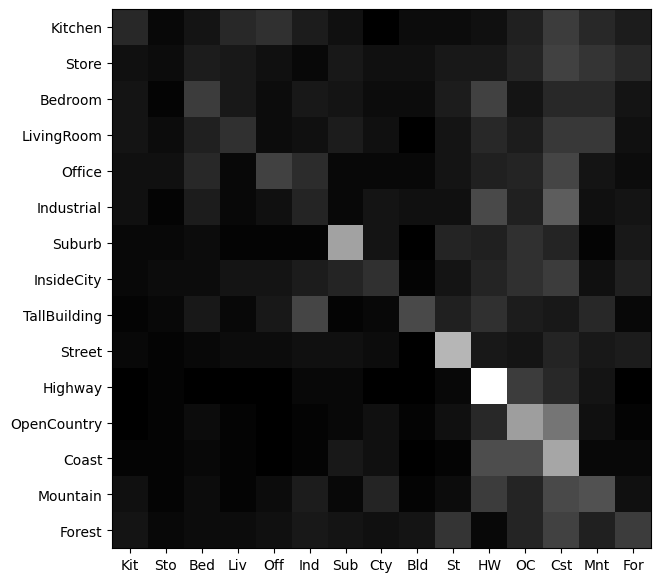

In [ ]:
########################## Best Params ##########################
k = 1
metric = 'correlation'
acc = projSceneRecBoW('tiny_image', 'nearest_neighbor', add_val=False, k=k, distance_metric=metric)

##Nearest_neighbor & Bag_of_words

In [ ]:
########################## Distance Metrics In cdist ###########################
# euclidean, cityblock, sqeuclidean,
# cosine, correlation, hamming, jaccard, jensenshannon, chebyshev, canberra
# braycurtis, yule, matching, dice, kulczynski1, rogerstanimoto,
# russellrao, sokalmichener, sokalsneath

In [ ]:
# when you are too lazy to make an educated guess
# just brute force it!
# simple equation.
Ks = [1,3,5,7,9,11]
metrics = ['braycurtis','canberra','chebyshev','cityblock','correlation','cosine','euclidean','jensenshannon','sqeuclidean']

acc_per_k_metric_2 = np.zeros((len(Ks),len(metrics)))
for i, k in enumerate(Ks):
  for j, metric in enumerate(metrics):
    acc_per_k_metric_2[i,j] = projSceneRecBoW('bag_of_words', 'nearest_neighbor', add_val=False, verbose = False, k = k, distance_metric = metric)
# NOTE: THIS CELL TAKES 7 HELLISH HOURS TO FINISH!!
# still not enough time to know the reason for our existance

In [ ]:
temp = acc_per_k_metric_2*100
temp = np.round(temp,3)
temp = temp.astype(str)
temp = np.char.add(temp, '%')
df = pd.DataFrame(temp, index=Ks, columns=metrics)
print(tabulate(df, headers=['K']+metrics, tablefmt = 'psql', numalign="center", stralign='center'))

+-----+--------------+------------+-------------+-------------+---------------+----------+-------------+-----------------+---------------+
|  K  |  braycurtis  |  canberra  |  chebyshev  |  cityblock  |  correlation  |  cosine  |  euclidean  |  jensenshannon  |  sqeuclidean  |
|-----+--------------+------------+-------------+-------------+---------------+----------+-------------+-----------------+---------------|
|  1  |   55.533%    |   54.0%    |   37.733%   |   55.533%   |    46.267%    |  50.6%   |   49.533%   |     55.333%     |    49.533%    |
|  3  |    57.0%     |  55.267%   |   38.867%   |    57.0%    |    47.067%    | 51.667%  |   50.933%   |     58.067%     |    50.933%    |
|  5  |    59.2%     |   57.6%    |   41.267%   |    59.2%    |     49.4%     |  52.8%   |   52.067%   |     59.467%     |    52.067%    |
|  7  |   59.333%    |   57.8%    |   40.867%   |   59.333%   |    47.933%    | 53.133%  |   52.867%   |     59.333%     |    52.867%    |
|  9  |   58.867%    |  57.

Getting paths and labels for all train and test data.
Using bag_of_words representation for images.
Loaded vocab from file.
Loaded vocab from file.
Using nearest_neighbor classifier to predict test set categories.
Creating results_webpage/index.html, thumbnails, and confusion matrix.
Accuracy (mean of diagonal of confusion matrix) is 59.467%
Wrote results page to static/index.html.


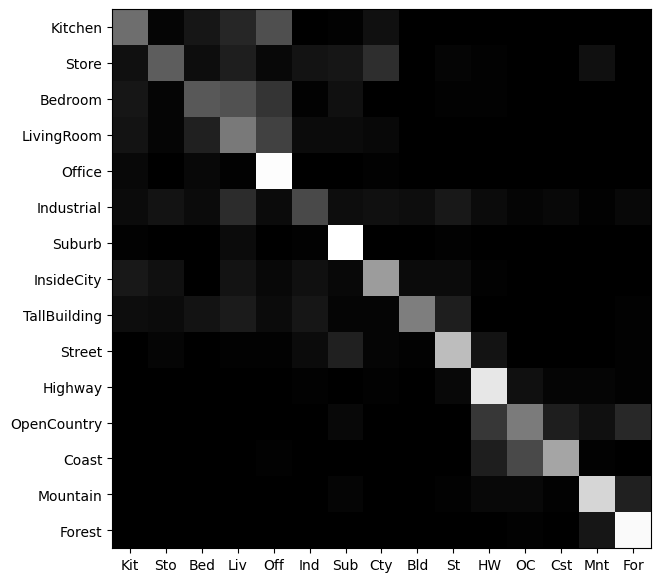

In [ ]:
########################## Best Params ##########################
k = 11
metric = 'cityblock'
acc = projSceneRecBoW('bag_of_words', 'nearest_neighbor', add_val=False, verbose=True, k=k, distance_metric=metric)

##Support_vector_machine & Bag_of_words

**Train the SVM with different kernels**

In [ ]:
kernels=['chi-sqr', 'rbf', 'linear', 'sigmoid','poly']
acc_per_kernel_3 = np.zeros((1,len(kernels)))
for i, kernel in enumerate(kernels):
    acc_per_kernel_3[0,i] = acc = projSceneRecBoW('bag_of_words', 'support_vector_machine', add_val=False, verbose=False, kernel=kernel)

In [ ]:
temp = acc_per_kernel_3*100
temp = np.round(temp,3)
temp = temp.astype(str)
temp = np.char.add(temp, '%')
df = pd.DataFrame(temp)
# displaying the DataFrame
print(tabulate(df, headers=kernels, tablefmt = 'psql', numalign="center", stralign='center', showindex=False))

+-----------+-------+----------+-----------+---------+
|  chi-sqr  |  rbf  |  linear  |  sigmoid  |  poly   |
|-----------+-------+----------+-----------+---------|
|  99.867%  | 65.2% |  65.8%   |  44.533%  | 66.133% |
+-----------+-------+----------+-----------+---------+


we will need to do some cross-validation on random splits to check if this number is not from the imaginary plane

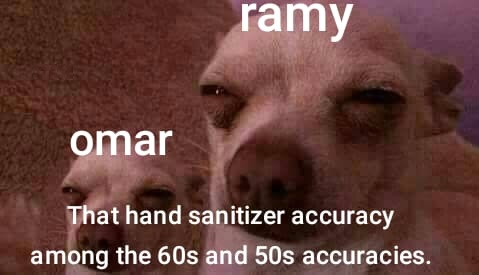

**Experiment with many different vocabulary sizes and report performance**

In [ ]:
# without validation set added
vocab_sizes = [10, 20, 50, 100, 200, 400, 800, 1000, 1600, 3200]
acc_per_vocab_4 = np.zeros((1,len(vocab_sizes)))
for i, size in enumerate(vocab_sizes):
  acc_per_vocab_4[0,i] = np.round(projSceneRecBoW('bag_of_words', 'support_vector_machine', add_val=False, verbose=False, vocab_size=size)*100, 3)

# huh, another 24+ hours invested in existential crisis.
# if you want to run this cell prepare for hell
# with multiple trials due to colab closing.

# my worst nightmare now is pressing 'run all' by mistake.
# fun fact we can't do the 10000 vocab with 100 iter on a free colab session
# it takes more than 12 hours. being poor feels amazing.

In [ ]:
temp = acc_per_vocab_4
temp = temp.astype(str)
temp = np.char.add(temp, '%')
df = pd.DataFrame(temp)
print(tabulate(df, headers = [str(s) for s in vocab_sizes], tablefmt = 'psql', numalign = "center", stralign = 'center', showindex = False))

+---------+-------+---------+---------+---------+---------+-------+---------+--------+---------+
|   10    |  20   |   50    |   100   |   200   |   400   |  800  |  1000   |  1600  |  3200   |
|---------+-------+---------+---------+---------+---------+-------+---------+--------+---------|
| 48.333% | 52.4% | 56.267% | 61.867% | 65.467% | 67.067% | 69.6% | 70.733% | 72.6%  | 72.867% |
+---------+-------+---------+---------+---------+---------+-------+---------+--------+---------+


In [ ]:
# with validation set added
vocab_sizes = [10, 20, 50, 100, 200, 400, 800, 1000, 1600, 3200]
acc_per_vocab_4_1 = np.zeros((1,len(vocab_sizes)))
for i, size in enumerate(vocab_sizes):
  acc_per_vocab_4_1[0,i] = np.round(projSceneRecBoW('bag_of_words', 'support_vector_machine', verbose=False, vocab_size=size)*100, 3)

In [ ]:
temp = acc_per_vocab_4_1
temp = temp.astype(str)
temp = np.char.add(temp, '%')
df = pd.DataFrame(temp)
print(tabulate(df, headers = [str(s) for s in vocab_sizes], tablefmt = 'psql', numalign = "center", stralign = 'center', showindex = False))

+-------+---------+---------+---------+-------+---------+---------+---------+--------+--------+
|  10   |   20    |   50    |   100   |  200  |   400   |   800   |  1000   |  1600  |  3200  |
|-------+---------+---------+---------+-------+---------+---------+---------+--------+--------|
| 50.0% | 56.333% | 61.333% | 61.533% | 65.4% | 68.467% | 71.867% | 72.267% | 73.8%  | 74.6%  |
+-------+---------+---------+---------+-------+---------+---------+---------+--------+--------+


Getting paths and labels for all train and test data.
Using bag_of_words representation for images.
Loaded vocab from file.
Loaded vocab from file.
Using support_vector_machine classifier to predict test set categories.
Creating results_webpage/index.html, thumbnails, and confusion matrix.
static
template
images
Accuracy (mean of diagonal of confusion matrix) is 99.867%
Wrote results page to static/index.html.


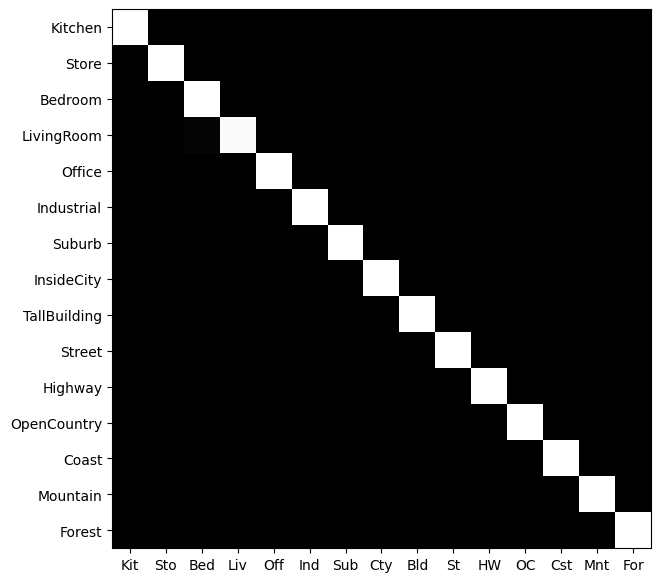

In [ ]:
# can't argue aganist the cross-val ¯\_(ツ)_/¯
# that unethical, unjustified and imaginary 100% acc wins.
acc = projSceneRecBoW('bag_of_words', 'support_vector_machine', kernel='chi-sqr', add_val=False, vocab_size = 200)

# Ignore this cell as we have figured out why and how this result occured.
# please refer to "Further Analysis On Chi-Sqr Kernel" section in the notebook

In [ ]:
# lets forget about this magical 100%
# and act as if we don't have a functioning model for a second, sorry 'for multiple of 24 hours'*.
# using the new added validation set to randomized gridsearch some parameters
acc = projSceneRecBoW('bag_of_words', 'support_vector_machine', fine_tune=True, kernel='rbf', vocab_size = 10)

# it is very tedious to call the projSceneRecBoW
# because we have to create the features with every call
# and since the vocab size is 3200 the time taken to create our features is almost 2 hours.
# so it makes sense to create the features first and save them in the vars.

In [ ]:
# set basic parameters
data_path = '/content/data/'
categories = ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office',
            'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street',
            'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest']

abbr_categories = ['Kit', 'Sto', 'Bed', 'Liv', 'Off', 'Ind', 'Sub',
                       'Cty', 'Bld', 'St', 'HW', 'OC', 'Cst', 'Mnt', 'For']

num_categories = 15
num_train_per_cat = 100

train_image_paths, test_image_paths, val_image_paths, train_labels, test_labels, val_labels = \
get_image_paths(data_path, categories, num_train_per_cat)

train_image_paths = np.append(train_image_paths, val_image_paths)
train_labels = np.append(train_labels, val_labels)

In [ ]:
# create our features
train_image_feats = get_bags_of_words(False, 3200, train_image_paths, (4,4), (4,4), "TCB", 0.29)
test_image_feats  = get_bags_of_words(False, 3200, test_image_paths,  (4,4), (4,4), "TCB", 0.29)

77.07% Accuarcy


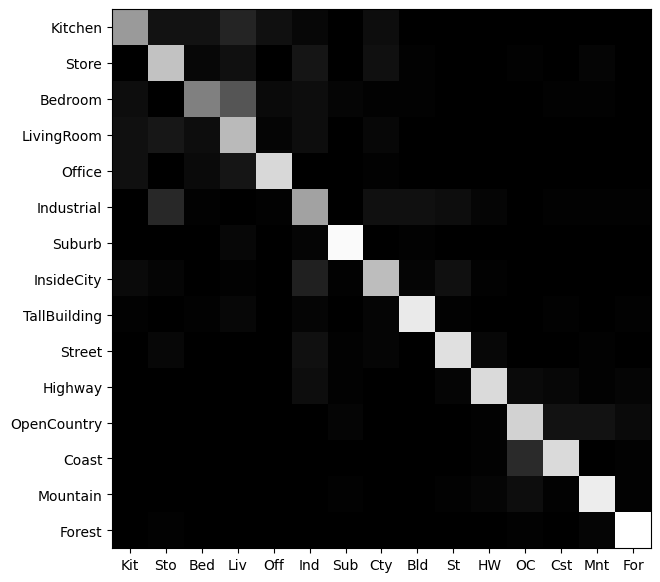

In [ ]:
# create svm
svc = SVC(kernel = 'poly', gamma = 'scale', C = 8, degree = 2, coef0 = 1.5)

#poly, C = 8, degree = 2, coef0 = 1.5 -> 77.07%

# train svm
svc.fit(train_image_feats, train_labels)

# predict test set
predicts = svc.predict(test_image_feats)

# create confusion matrix and calculate mean of diagonal accuracies
categories = np.array(categories)
predicted_categories = np.array(predicts)
test_labels = np.array(test_labels)
confusion_matrix = np.zeros((num_categories, num_categories))

for i, cat in enumerate(predicted_categories):
    row = np.argwhere(categories == test_labels[i])[0][0]
    column = np.argwhere(categories == predicted_categories[i])[0][0]
    confusion_matrix[row][column] += 1

num_test_per_cat = len(test_labels) / num_categories
confusion_matrix = confusion_matrix / float(num_test_per_cat)
accuarcy = np.mean(np.diag(confusion_matrix))*100

# print and visualize
print(f'{np.round(accuarcy, 2)}% Accuarcy')
plt.figure(figsize=(7,7))
plt.imshow(confusion_matrix, cmap="gray", interpolation="nearest")
_ , _ = plt.xticks(np.arange(num_categories), abbr_categories)
_ , _ = plt.yticks(np.arange(num_categories), categories)

## Cross-Validation
### The cells before cross validation are like the dark ages
### Full of ignorant, slow and brute codes.

In [ ]:
kernels = ['chi-sqr', 'rbf', 'linear', 'sigmoid', 'poly']
acc_per_kernel_codetype_5 = np.zeros((1,len(kernels))).astype(str)

for i, kernel in enumerate(kernels):
  print(f'\n{kernel}')
  acc_per_kernel_codetype_5[0,i] = cross_val( num_iterations = 5,
                                                    num_samples = 300, FEATURE = 'bag_of_words', CLASSIFIER = 'support_vector_machine',
                                                    kernel = kernel, vocab_size = 200)



chi-sqr
Iteration 1 Done with 100.0% Accuarcy
Iteration 2 Done with 100.0% Accuarcy
Iteration 3 Done with 100.0% Accuarcy
Iteration 4 Done with 100.0% Accuarcy
Iteration 5 Done with 100.0% Accuarcy
Using support_vector_machine & bag_of_words
The Avg Accuarcy is 100.0% ± 0.0%

rbf
Iteration 1 Done with 50.67% Accuarcy
Iteration 2 Done with 53.33% Accuarcy
Iteration 3 Done with 53.67% Accuarcy
Iteration 4 Done with 54.33% Accuarcy
Iteration 5 Done with 53.0% Accuarcy
Using support_vector_machine & bag_of_words
The Avg Accuarcy is 53.0% ± 1.25%

linear
Iteration 1 Done with 54.0% Accuarcy
Iteration 2 Done with 54.33% Accuarcy
Iteration 3 Done with 53.33% Accuarcy
Iteration 4 Done with 50.67% Accuarcy
Iteration 5 Done with 61.33% Accuarcy
Using support_vector_machine & bag_of_words
The Avg Accuarcy is 54.73% ± 3.54%

sigmoid
Iteration 1 Done with 42.0% Accuarcy
Iteration 2 Done with 38.33% Accuarcy
Iteration 3 Done with 38.33% Accuarcy
Iteration 4 Done with 40.33% Accuarcy
Iteration 5 Don

In [ ]:
df = pd.DataFrame(acc_per_kernel_codetype_5, columns=kernels)
print(tabulate(df, headers = kernels, tablefmt = 'psql', numalign = "center", stralign = 'center', showindex = False))

+---------------+---------------+----------------+---------------+----------------+
|    chi-sqr    |      rbf      |     linear     |    sigmoid    |      poly      |
|---------------+---------------+----------------+---------------+----------------|
| 100.0% ± 0.0% | 53.0% ± 1.25% | 54.73% ± 3.54% | 40.8% ± 2.51% | 52.93% ± 2.38% |
+---------------+---------------+----------------+---------------+----------------+


In [ ]:
vocab_sizes = [10, 20, 50, 100, 200, 400, 800, 1000, 1600, 3200]
acc_per_vocab_4 = np.zeros((1,len(vocab_sizes))).astype(str)
for i, size in enumerate(vocab_sizes):
    print(f'\nVocab size {size}')
    acc_per_vocab_4[0,i] = cross_val( num_iterations = 7,
                                      num_samples = 300, FEATURE = 'bag_of_words', CLASSIFIER = 'support_vector_machine',
                                      vocab_size = size)


Vocab size 10
Iteration 1 Done with 43.67% Accuarcy
Iteration 2 Done with 37.0% Accuarcy
Iteration 3 Done with 42.0% Accuarcy
Iteration 4 Done with 36.67% Accuarcy
Iteration 5 Done with 33.67% Accuarcy
Iteration 6 Done with 37.0% Accuarcy
Iteration 7 Done with 38.67% Accuarcy
Using support_vector_machine & bag_of_words
The Avg Accuarcy is 38.38% ± 3.16%

Vocab size 20
Iteration 1 Done with 44.0% Accuarcy
Iteration 2 Done with 42.33% Accuarcy
Iteration 3 Done with 42.33% Accuarcy
Iteration 4 Done with 39.0% Accuarcy
Iteration 5 Done with 37.0% Accuarcy
Iteration 6 Done with 45.33% Accuarcy
Iteration 7 Done with 48.0% Accuarcy
Using support_vector_machine & bag_of_words
The Avg Accuarcy is 42.57% ± 3.44%

Vocab size 50
Iteration 1 Done with 52.67% Accuarcy
Iteration 2 Done with 46.33% Accuarcy
Iteration 3 Done with 46.33% Accuarcy
Iteration 4 Done with 44.33% Accuarcy
Iteration 5 Done with 51.67% Accuarcy
Iteration 6 Done with 51.33% Accuarcy
Iteration 7 Done with 51.0% Accuarcy
Using s

In [ ]:
df = pd.DataFrame(acc_per_vocab_4)
print(tabulate(df, headers = [str(s) for s in vocab_sizes], tablefmt = 'psql', numalign = "center", stralign = 'center', showindex = False))

+----------------+----------------+---------------+----------------+----------------+----------------+---------------+----------------+----------------+---------------+
|       10       |       20       |      50       |      100       |      200       |      400       |      800      |      1000      |      1600      |     3200      |
|----------------+----------------+---------------+----------------+----------------+----------------+---------------+----------------+----------------+---------------|
| 38.38% ± 3.16% | 42.57% ± 3.44% | 49.1% ± 3.07% | 52.19% ± 3.01% | 54.62% ± 3.57% | 57.57% ± 3.36% | 58.1% ± 1.44% | 59.81% ± 3.05% | 60.05% ± 2.77% | 61.0% ± 2.96% |
+----------------+----------------+---------------+----------------+----------------+----------------+---------------+----------------+----------------+---------------+
+----------------+----------------+---------------+----------------+----------------+----------------+---------------+----------------+----------------+---

## KCB vs TCB
## Kernel codebook vs Traditional codebook

In [ ]:
# As mentioned in the paper
# the value of sigma aka the size of the kernel depends
# on length of features, dataset and the range of the feature values.
# thus we will use cross val to determine the best sigma or atleast try :D
sigmas = np.arange(1, 110, 10)
acc_per_KCB_sigma_6 = np.zeros((1,len(sigmas))).astype(str)

for i, sig in enumerate(sigmas):
  print(f'\nkernel size = {sig:.3f}')
  acc_per_KCB_sigma_6[0,i] = cross_val( num_iterations = 5,
                                        num_samples = 100, FEATURE = 'bag_of_words', CLASSIFIER = 'support_vector_machine',
                                        kernel = 'rbf', coding_type = 'KCB', sigma = sig, vocab_size = 200)

In [ ]:
slice_factor = 5
for i in range(int(len(sigmas)/slice_factor)+1):
  hdrs = np.round(sigmas[slice_factor*i:slice_factor*(i+1)], 3).astype(str)
  df = pd.DataFrame(acc_per_KCB_sigma_6[:,slice_factor*i: slice_factor*(i+1)])
  if(i == int(len(sigmas)/slice_factor)):
    hdrs = np.round(sigmas[slice_factor*i: ], 3).astype(str)
    df = pd.DataFrame(acc_per_KCB_sigma_6[:, slice_factor*i:])
  print(tabulate(df, headers = hdrs, tablefmt = 'psql', numalign = "center", stralign = 'center', showindex = False))

+--------------+---------------+---------------+---------------+---------------+
|      1       |      11       |      21       |      31       |      41       |
|--------------+---------------+---------------+---------------+---------------|
| 36.0% ± 5.1% | 34.6% ± 4.76% | 34.2% ± 4.96% | 30.8% ± 6.21% | 36.2% ± 2.04% |
+--------------+---------------+---------------+---------------+---------------+
+---------------+---------------+---------------+--------------+---------------+
|      51       |      61       |      71       |      81      |      91       |
|---------------+---------------+---------------+--------------+---------------|
| 36.6% ± 6.71% | 31.2% ± 4.26% | 36.6% ± 1.85% | 34.6% ± 5.0% | 35.8% ± 5.74% |
+---------------+---------------+---------------+--------------+---------------+
+---------------+
|      101      |
|---------------|
| 33.6% ± 5.54% |
+---------------+


In [ ]:
sigmas = np.arange(0.30, 4, 0.05)
acc_per_KCB_sigma_7 = np.zeros((1,len(sigmas))).astype(str)

for i, sig in enumerate(sigmas):
  print(f'\nkernel size = {sig:.3f}')
  acc_per_KCB_sigma_6[0,i] = cross_val( num_iterations = 5,
                                        num_samples = 100, FEATURE = 'bag_of_words', CLASSIFIER = 'support_vector_machine',
                                        kernel = 'rbf', coding_type = 'KCB', sigma = sig, vocab_size = 200)


In [ ]:
slice_factor = 10
for i in range(int(len(sigmas)/slice_factor)+1):
  hdrs = np.round(sigmas[slice_factor*i:slice_factor*(i+1)], 3).astype(str)
  df = pd.DataFrame(acc_per_KCB_sigma_7[:,slice_factor*i: slice_factor*(i+1)])
  if(i == int(len(sigmas)/slice_factor)):
    hdrs = np.round(sigmas[slice_factor*i: ], 3).astype(str)
    df = pd.DataFrame(acc_per_KCB_sigma_7[:, slice_factor*i:])
  print(tabulate(df, headers = hdrs, tablefmt = 'psql', numalign = "center", stralign = 'center', showindex = False))

+---------------+---------------+---------------+---------------+---------------+--------------+---------------+---------------+---------------+---------------+
|      0.3      |     0.35      |      0.4      |     0.45      |      0.5      |     0.55     |      0.6      |     0.65      |      0.7      |     0.75      |
|---------------+---------------+---------------+---------------+---------------+--------------+---------------+---------------+---------------+---------------|
| 39.6% ± 5.85% | 35.6% ± 4.72% | 38.8% ± 4.31% | 38.6% ± 3.44% | 39.4% ± 5.99% | 37.0% ± 4.0% | 34.2% ± 3.54% | 34.0% ± 1.26% | 33.0% ± 2.83% | 37.0% ± 4.73% |
+---------------+---------------+---------------+---------------+---------------+--------------+---------------+---------------+---------------+---------------+
+---------------+---------------+---------------+---------------+---------------+--------------+---------------+---------------+---------------+---------------+
|      0.8      |     0.85      | 

In [ ]:
# with zero guidance to how the **** we can find this magic number
# named sigma, we desperately continue the brute search.
sigmas = np.arange(0.01, 0.31, 0.01)
acc_per_KCB_sigma_8 = np.zeros((1,len(sigmas))).astype(str)

for i, sig in enumerate(sigmas):
  print(f'\nkernel size = {sig:.3f}')
  acc_per_KCB_sigma_8[0,i] = cross_val( num_iterations = 5,
                                        num_samples = 100, FEATURE = 'bag_of_words', CLASSIFIER = 'support_vector_machine',
                                        kernel = 'rbf', coding_type = 'KCB', sigma = sig, vocab_size = 200)

In [ ]:
slice_factor = 10
for i in range(int(len(sigmas)/slice_factor)+1):
  hdrs = np.round(sigmas[slice_factor*i:slice_factor*(i+1)], 3).astype(str)
  df = pd.DataFrame(acc_per_KCB_sigma_8[:,slice_factor*i: slice_factor*(i+1)])
  if(i == int(len(sigmas)/slice_factor)):
    hdrs = np.round(sigmas[slice_factor*i: ], 3).astype(str)
    df = pd.DataFrame(acc_per_KCB_sigma_8[:, slice_factor*i:])
  print(tabulate(df, headers = hdrs, tablefmt = 'psql', numalign = "center", stralign = 'center', showindex = False))

+---------------+---------------+---------------+--------------+---------------+--------------+---------------+---------------+---------------+--------------+
|     0.01      |     0.02      |     0.03      |     0.04     |     0.05      |     0.06     |     0.07      |     0.08      |     0.09      |     0.1      |
|---------------+---------------+---------------+--------------+---------------+--------------+---------------+---------------+---------------+--------------|
| 14.2% ± 2.04% | 13.6% ± 1.85% | 13.0% ± 2.28% | 13.0% ± 2.1% | 13.0% ± 1.41% | 11.6% ± 0.8% | 13.4% ± 2.06% | 12.4% ± 1.96% | 12.2% ± 1.47% | 12.8% ± 1.6% |
+---------------+---------------+---------------+--------------+---------------+--------------+---------------+---------------+---------------+--------------+
+---------------+---------------+---------------+--------------+---------------+---------------+---------------+---------------+---------------+---------------+
|     0.11      |     0.12      |     0.13  

In [ ]:
# Noticed that the KCB works will with
# poly and rbf but not chi-sqr(expected because features are not histograms anymore) and linear
# compare rbf with and without KCB
headers = ['TCB','KCB']
Accs = [0, 0]

Accs[0] = np.round(projSceneRecBoW('bag_of_words', 'support_vector_machine', verbose=False,
                                    vocab_size = 200,  kernel = 'rbf')*100, 3)

Accs[1] = np.round(projSceneRecBoW('bag_of_words', 'support_vector_machine', verbose=False,
                                    vocab_size = 200,  kernel = 'rbf',
                                    sigma = 0.29, coding_type = 'KCB' )*100, 3)


In [ ]:
temp = np.array(Accs).reshape(1,-1)
temp = temp.astype(str)
temp = np.char.add(temp, '%')
df = pd.DataFrame(temp)
print(tabulate(df, headers = headers, tablefmt = 'psql', numalign = "center", stralign = 'center', showindex = False))

+-------+---------+
|  TCB  |   KCB   |
|-------+---------|
| 65.2% | 52.933% |
+-------+---------+


All hope is lost.

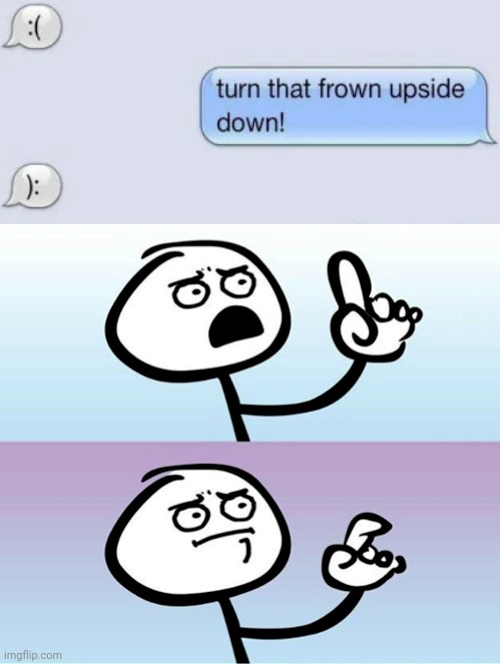

##Naive_Bayes_Nearest_neighbor & Bag_of_words
The main difference between this and the paper
is how we extracted the features.

In the paper they used SIFT here we are using HOG.

For this to perform better we will need to try a multi descriptor approach

In [ ]:
acc = cross_val(num_iterations = 5,
      num_samples = 200, FEATURE = 'bag_of_words', CLASSIFIER = 'nearest_neighbor', nbnn=True, vocab_size = 200)

Iteration 1 Done with 43.5% Accuarcy
Iteration 2 Done with 46.0% Accuarcy
Iteration 3 Done with 35.0% Accuarcy
Iteration 4 Done with 40.5% Accuarcy
Iteration 5 Done with 38.0% Accuarcy
Using nearest_neighbor & bag_of_words
The Avg Accuarcy is 40.6% ± 3.89%


Getting paths and labels for all train and test data.
Using bag_of_words representation for images.
Loaded vocab from file.
Loaded vocab from file.
Using nearest_neighbor classifier to predict test set categories.
Creating results_webpage/index.html, thumbnails, and confusion matrix.
Accuracy (mean of diagonal of confusion matrix) is 52.467%
Wrote results page to static/index.html.


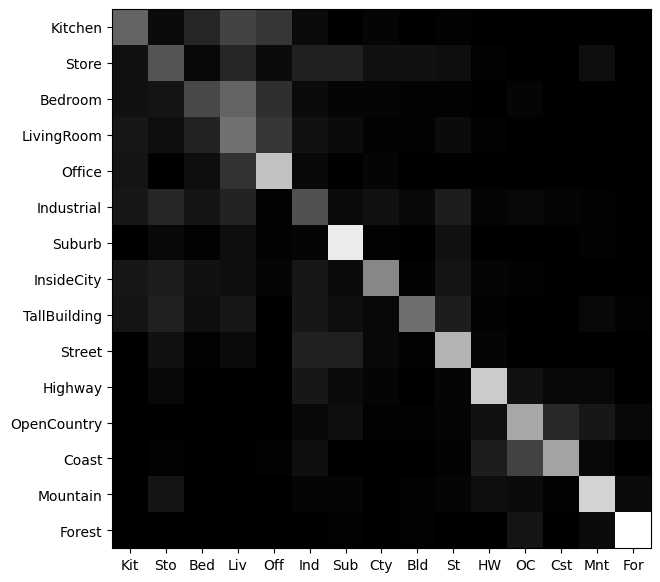

In [ ]:
acc = projSceneRecBoW('bag_of_words', 'nearest_neighbor', nbnn=True, vocab_size = 200)

## Report performance on the 397-category SUN database

We can do this but enough insanity for this project.

we can simply use https://www.tensorflow.org/datasets/catalog/sun397

##Add additional complementary features GIST descriptors

Same as SUN397 we can simply use https://github.com/whitphx/lear-gist-python

but the catch is, not to go crazy.

# Further Analysis On Chi-Sqr Kernel

In [ ]:
# set basic parameters
data_path = '/content/data/'
categories = ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office',
            'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street',
            'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest']
num_categories = 15
num_train_per_cat = 100

train_image_paths, test_image_paths, val_image_paths, train_labels, test_labels, val_labels = \
get_image_paths(data_path, categories, num_train_per_cat)
cells_per_block, pixels_per_cell = (4,4), (4,4)
coding_type, sigma = "TCB", 0.29
verbose = False
vocab_size = 50

In [ ]:
# create our features
train_image_feats = get_bags_of_words(verbose, vocab_size, train_image_paths, cells_per_block, pixels_per_cell, coding_type, sigma)
test_image_feats  = get_bags_of_words(verbose, vocab_size, test_image_paths, cells_per_block, pixels_per_cell, coding_type, sigma)

In [ ]:
print(train_image_feats)

[[ 11.  56.  26. ...  35.  47.  45.]
 [  4.  52.  24. ...  32.  43.  39.]
 [ 36.  81.  46. ...  45.  20.  17.]
 ...
 [ 88.   5.   0. ...  19.  18.  40.]
 [215.   0.   0. ...   0.  12.  78.]
 [  2.   0.   0. ...   8.  35.   6.]]


In [ ]:
print(test_image_feats)

[[ 39. 121.  17. ...  19.  31.  23.]
 [ 88.  26.  58. ...  53.  19.  76.]
 [ 53.  88.  12. ...  28.  10.  31.]
 ...
 [ 18.   0.   0. ...  11.  88.  34.]
 [ 13.   0.   0. ...   3.  70.  24.]
 [  6.   0.   1. ...   9.  40.  28.]]


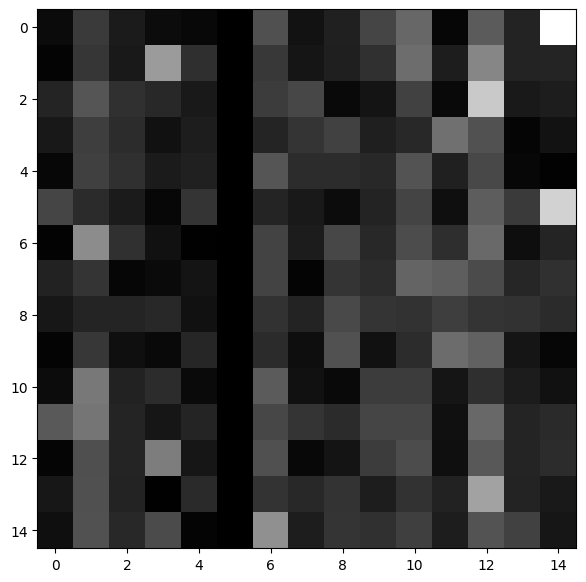

In [ ]:
# now lets Visualize our features before and after the kernel
plt.figure(figsize=(7,7))
plt.imshow(train_image_feats[:15,:15], cmap="gray", interpolation="nearest")

In [ ]:
# create svm
svc = SVC(kernel = 'precomputed')

# apply this magical kernel
train_image_feats_new = chi2_kernel(train_image_feats)
test_image_feats_new = chi2_kernel(test_image_feats)

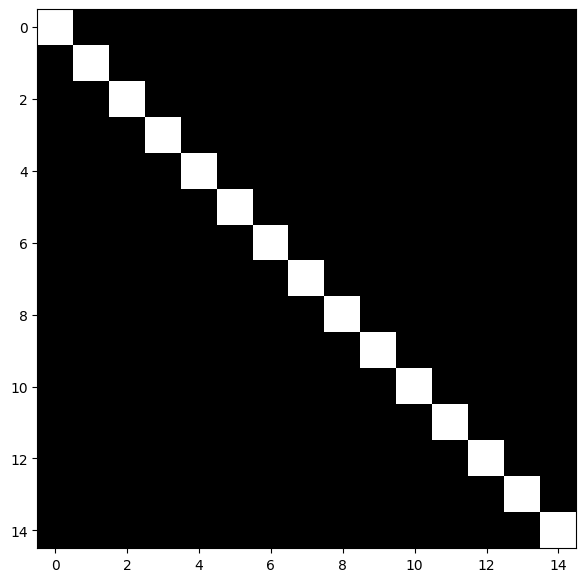

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(train_image_feats_new[:15,:15], cmap="gray", interpolation="nearest")

In [ ]:
print(train_image_feats_new)

[[1.00000000e+000 5.63365659e-299 4.46857250e-297 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [5.63365659e-299 1.00000000e+000 2.52271093e-240 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [4.46857250e-297 2.52271093e-240 1.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 ...
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 1.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  1.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 1.00000000e+000]]


In [ ]:
print(test_image_feats_new)

[[1.00000000e+000 0.00000000e+000 5.85994946e-287 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [5.85994946e-287 0.00000000e+000 1.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 ...
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 1.00000000e+000
  3.26280953e-320 3.67471497e-160]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 3.26280953e-320
  1.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 3.67471497e-160
  0.00000000e+000 1.00000000e+000]]


In [ ]:
svc.fit(train_image_feats_new, train_labels)
predicts = svc.predict(test_image_feats_new)

In [ ]:
print(predicts)

['Kitchen' 'Kitchen' 'Kitchen' ... 'Forest' 'Forest' 'Forest']


In [ ]:
categories = np.array(categories)
predicted_categories = np.array(predicts)
test_labels = np.array(test_labels)
confusion_matrix = np.zeros((num_categories, num_categories))

for i, cat in enumerate(predicted_categories):
    row = np.argwhere(categories == test_labels[i])[0][0]
    column = np.argwhere(categories == predicted_categories[i])[0][0]
    confusion_matrix[row][column] += 1

num_test_per_cat = len(test_labels) / num_categories
confusion_matrix = confusion_matrix / float(num_test_per_cat)
accuarcy = np.mean(np.diag(confusion_matrix))*100
print(f'{np.round(accuarcy, 2)}% Accuarcy')

99.87% Accuarcy


It seems that I actually understand what happend here.
the svm figured out the order in which the classes are provided since the data is created sequentially where we add 100 images of each class to our set.

we can try to shuffle the data and see if this fixes it.

In [ ]:
p_train = np.random.permutation(len(train_image_paths))
p_test = np.random.permutation(len(test_image_paths))

In [ ]:
# but lets shuffle the data first
train_image_paths_shuffled = train_image_paths[p_train]
test_image_paths_shuffled = test_image_paths[p_test]

train_labels_shuffled = train_labels[p_train]
test_labels_shuffled = test_labels[p_test]

In [ ]:
# create our features
train_image_feats_shuffled = get_bags_of_words(verbose, vocab_size, train_image_paths_shuffled, cells_per_block, pixels_per_cell, coding_type, sigma)
test_image_feats_shuffled  = get_bags_of_words(verbose, vocab_size, test_image_paths_shuffled, cells_per_block, pixels_per_cell, coding_type, sigma)

In [ ]:
# create svm
svc = SVC(kernel = 'precomputed')
# apply this magical kernel
train_image_feats_new = chi2_kernel(train_image_feats_shuffled)
test_image_feats_new = chi2_kernel(test_image_feats_shuffled)

In [ ]:
svc.fit(train_image_feats_new, train_labels_shuffled)
predicts = svc.predict(test_image_feats_new)

In [ ]:
categories = np.array(categories)
predicted_categories = np.array(predicts)
test_labels_shuffled = np.array(test_labels_shuffled)
confusion_matrix = np.zeros((num_categories, num_categories))

for i, cat in enumerate(predicted_categories):
    row = np.argwhere(categories == test_labels_shuffled[i])[0][0]
    column = np.argwhere(categories == predicted_categories[i])[0][0]
    confusion_matrix[row][column] += 1

num_test_per_cat = len(test_labels_shuffled) / num_categories
confusion_matrix = confusion_matrix / float(num_test_per_cat)
accuarcy = np.mean(np.diag(confusion_matrix))*100
print(f'{np.round(accuarcy, 2)}% Accuarcy')

7.07% Accuarcy


This makes absoulate sense now, since each sample in train set is represented by 1 on the diagonal after the kernel and the fact that our data is not shuffled the svm "that sneaky basterd" gave us the trivial solution. where the labels are similar to the train labels.


and since the kernel does the same thing to test features and makes a diagonal of ones the prediction is the train labels and in our funny case the train labels are ordered as the test labels

Oh my god.

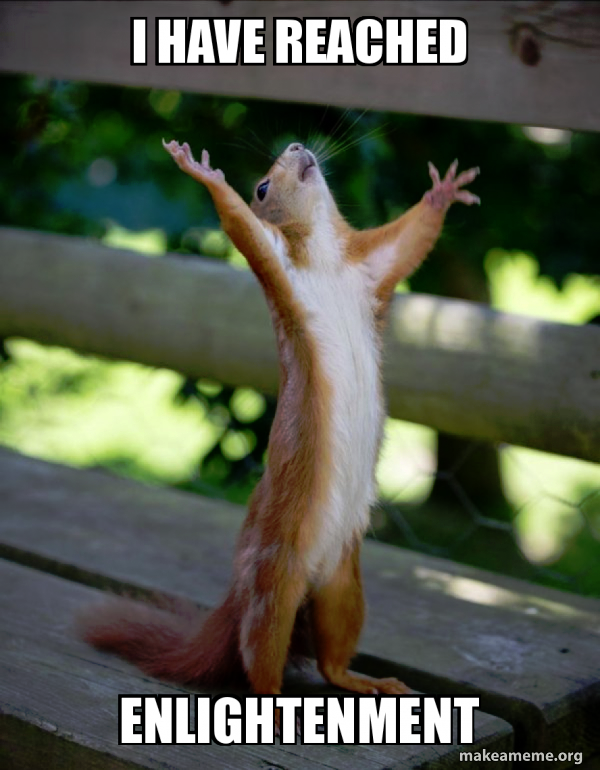